In [1]:
import sys, os
import imp
import time

sys.path.insert(0,"D:/My_python_libs/qsweepy")

from numpy import *
from importlib import reload
from matplotlib.pyplot import *

import qsweepy.libraries.instruments as instruments
from qsweepy.instrument_drivers._QubitDAQ.reg_intf import *
from qsweepy.instrument_drivers._QubitDAQ.usb_intf import *
import qsweepy.instrument_drivers._QubitDAQ.driver as drv

Failed loading module Keysight_M3102A:  No module named 'keysightSD1'
Failed loading module Keysight_M3202A:  No module named 'keysightSD1'
Failed loading module Labbrick:  [WinError 126] Не найден указанный модуль
Failed loading module ziUHF:  cannot import name 'ZIDevice' from 'qsweepy.instrument_drivers.zihdawg' (D:/My_python_libs/qsweepy\qsweepy\instrument_drivers\zihdawg.py)


## Connect to the DAQ board

In [9]:
try: del adc
except: pass
"""Use serial number string to identify the device. You can find the serial number in the USB device descriptor which can be
accessed using libusb Test utility or Windows Device Manager or other tool. The device name is "Cypress FX3 USB StreamerExample
Device", vendor ID is 0x04b4 and product ID is 0x00f1"""
adc = drv.Device("0009052001481708")

ADS54J40 already programmed


## Run data acquisition

In [36]:
"""Set the number of samples. Make shure it's not higher than 8192 if you want to use hardware averaging and dot product 
calculation. Otherwice raw data will be still captured in DDR3 memory, but dot products and averaged data will be incorrect.
The number of samples must be divisible by 8."""
adc.nsamp = 8192
"""Set number of segments"""
adc.nsegm = 10000
"""Choose trigger mode external "ext" or manual "man" """
adc.trig_mode = "ext"
"""Dta aquisition start can be delayed relative to the trigger."""
adc.set_trig_delay(200e-9)
"""Setup trigger generator. Output of this generator TRIG OUT A must be connected to the external trigger input TRIG IN and
also feed as a signal to one of  the signal inputs via 10 dB attenuator."""
adc.set_trig_src_period(10000)
adc.set_trig_src_width( 200)
"""Start data acquisition. This function will work only with an external trigger"""
adc.start_wait_done()

True

## Get captured data from DDR3 memory

Load time: 2.555225e+00 s


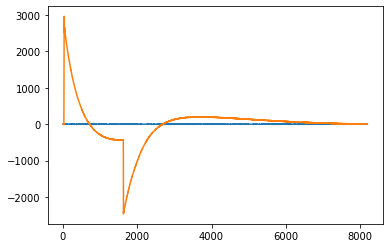

In [44]:
t1 = time.time()
rd_data = adc.get_data()
t2 = time.time()
print("Load time: {:e} s".format(t2-t1))
#Plot only first segment 
plot(rd_data[0].real.T)
plot(rd_data[0].imag.T)

## Get averaged over segments data

Load time: 1.995325e-03 s


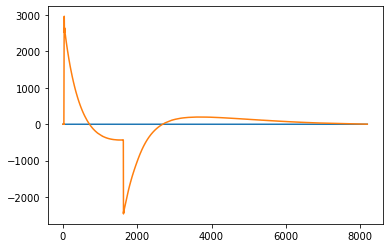

In [46]:
t1 = time.time()
aver_data = adc.get_averaged_data()
t2 = time.time()
print("Load time: {:e} s".format(t2-t1))
plot(aver_data.real)
plot(aver_data.imag)

## Load feature into the device

In [33]:
feature = rd_data[0]
adc.set_feature(feature, 0)
adc.set_feature(feature, 1)
adc.set_feature(feature, 2)
adc.set_feature(feature, 3)

## Read dot products and verify

Re run step 2 to get valueble data on this stage

In [42]:
"""Read dot product values. Number of rows corresponds to the number of segments and columns are correspond to 
4 state discrimination channels"""
dot_prod = adc.get_dot_prods()
print("Dot products:\n", dot_prod)

"""Read averaged over segments dot products"""
print("\nAveraged dot products:")
print(adc.get_dot_prod_ave() )

"""Read raw data from DDR3 memory and calculate dot products with reature"""
def dot_calc(data, feature):
    feature_max = np.max(np.abs(feature))
    if feature_max !=0:
        feature = 2**(14-1) * feature/feature_max
    res = zeros(len(data), dtype = int64)
    for i,d in enumerate(data):
        #d=d[8:]
        res[i] = int64(sum(d.real * int16(feature.real))+ sum(d.imag * int16(feature.imag)))
    return res
"""Verify that the result is the same as the hardware calculated values"""
print("\nCalculated dot products:")
print(dot_calc(adc.get_data(), feature))

"""Set thresholds. Just any values."""
adc.threshold[0]=6922839697
adc.threshold[1]=6922839697-1
adc.threshold[2]=6922839697-2
adc.threshold[3]=6922839697-3
"""Get discriminated states using the above thresholds"""
print("\nStates:\n", adc.get_states())

Dot products:
 [[6953027595 6953027595 6953027595 6953027595]
 [6953260213 6953260213 6953260213 6953260213]
 [6954411933 6954411933 6954411933 6954411933]
 ...
 [6954130159 6954130159 6954130159 6954130159]
 [6954966362 6954966362 6954966362 6954966362]
 [6953619060 6953619060 6953619060 6953619060]]

Averaged dot products:
[6.95338773e+09 6.95338773e+09 6.95338773e+09 6.95338773e+09]

Calculated dot products:
[6953027595 6953260213 6954411933 ... 6954130159 6954966362 6953619060]

States:
 [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 ...
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
